Import Libraries

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

## Gym Agent and Environment Class

#### Things to Consider 
1. This is limited to drilling interactions, production is not considered in reward
2. SHL is selected by user but should be something we included in the optimization 
3. The action and observations space logic must be preserved for the RL Q-Learning Flow, but the logic is not really dependant on these
4. Collision logic just prevents agents from wrapping around environment on Eastern and Western boundaries. It also prevents from hitting boundaries North and South. Logic just causes a bounce back effect that forces the agent to perform the opposite action ex: if it is going east and hits a boundary, it will go west for that action instead. 
5. Realistically all that can be optimized now is drilling direction based on available drill pipe


All models are created using tiled, here is the download link https://www.mapeditor.org/

location = [row,col]

In [2]:
from wildcatter.environment import SimpleDriller

Create the Env Object

In [3]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=50, delim=",")

env = SimpleDriller(env_config)

episodes = 1
for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
    score = 0

    while not done:
        # env.render()
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        score += reward

    print(f"Final Trajectory:{env.trajectory}")
    print("Campaign:{} Score:{}".format(episode, score))
    print("------------------------------------------")

Beginning Drill Campaign: 1
Final Trajectory:[[1, 79], [1, 78], [2, 78], [2, 77], [3, 77], [4, 77], [4, 78], [4, 79], [3, 79], [3, 78]]
Campaign:1 Score:0.0
------------------------------------------


## Actual Execution of Agent/Env Interactions

There are some basic print statements to help users understand what is going on since we don't have a UI or pygame visual to analyze.

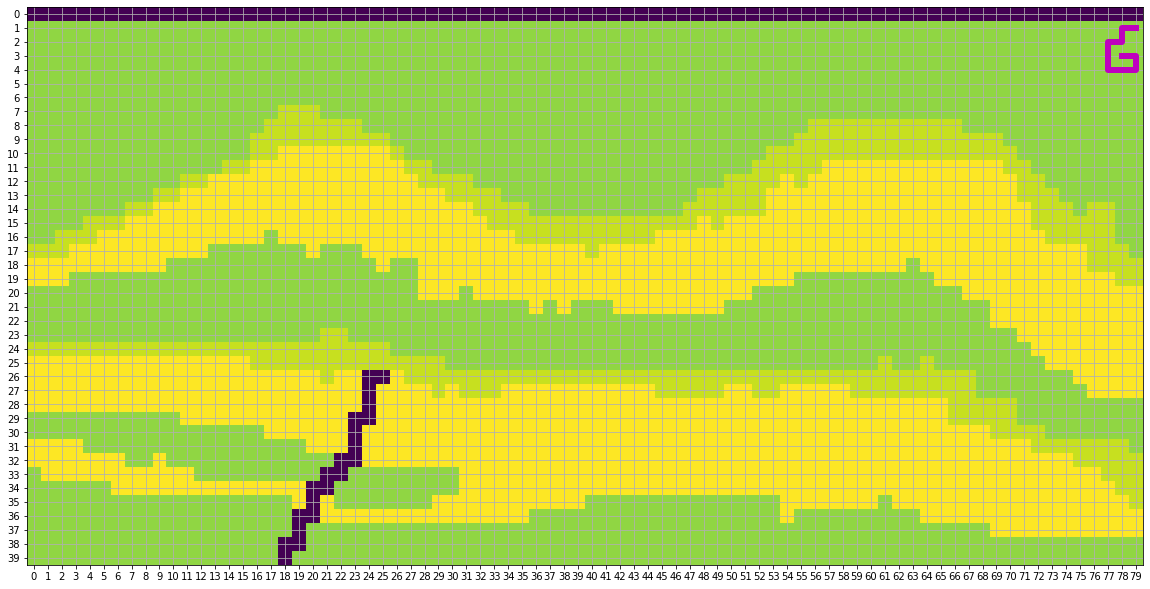

In [4]:
df = pd.DataFrame(env.trajectory, columns=["rows", "colums"])

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.grid()
plt.plot(df["colums"], df["rows"], "-", c="m", linewidth=6)

## PPO TESTS

In [9]:
from ray.tune.logger import pretty_print
from ray.rllib.agents.ppo import PPOTrainer
import ray

# Configure the algorithm.
config = {
    "num_workers": 1,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [64, 64],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "render_env": False,
    },
}

env_config = {
    "model_path": r"data/2d_stacked.csv",
    "available_pipe": 50,
    "delim": ",",
}

config["env_config"] = env_config

try:
    ray.init()
except RuntimeError:
    ray.shutdown()
    ray.init()

agent = PPOTrainer(config=config, env=SimpleDriller)

for i in range(100):
    # Perform one iteration of training the policy with PPO
    result = agent.train()

    if i % 25 == 0:
        checkpoint = agent.save()
        print("checkpoint saved at", checkpoint)

print(pretty_print(result))

2022-06-26 22:39:46,341	WARNING trainer.py:2540 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
(RolloutWorker pid=26440) 2022-06-26 22:39:47,530	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-06-26 22:39:47,558	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-06-26 22:39:47,559	WARNING trainer.py:2540 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.

agent_timesteps_total: 400000
counters:
  num_agent_steps_sampled: 400000
  num_agent_steps_trained: 400000
  num_env_steps_sampled: 400000
  num_env_steps_trained: 400000
custom_metrics: {}
date: 2022-06-26_22-36-03
done: false
episode_len_mean: 46.07
episode_media: {}
episode_reward_max: 105.0
episode_reward_mean: 51.58
episode_reward_min: 0.0
episodes_this_iter: 87
episodes_total: 9151
experiment_id: 5c8a0ce325bb43fdbfc48ff86af365ed
hostname: Tunas-MBP
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.1351524353027344
        cur_lr: 5.0000000000000016e-05
        entropy: 0.9303349953184845
        entropy_coeff: 0.0
        kl: 0.01656992954417302
        policy_loss: -0.023239906389586708
        total_loss: 8.470313142961071
        vf_explained_var: 0.0020984554162589452
        vf_loss: 8.491313570289202
      model: {}
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 400000


To see tensorboard run this from CLI.

Note Ray needs `grpcio`. On new Macs this has to be installed from conda or be built from scratch for M1 silicon.

The pip version doesn't work, and ray crashes.

```shell
tensorboard --logdir ~/ray_results/
```

In [6]:
# instantiate env class
env = SimpleDriller(env_config)

# run until episode ends
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

trajectory = env.trajectory
print(episode_reward)

2022-06-26 22:36:03,088	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


65.0


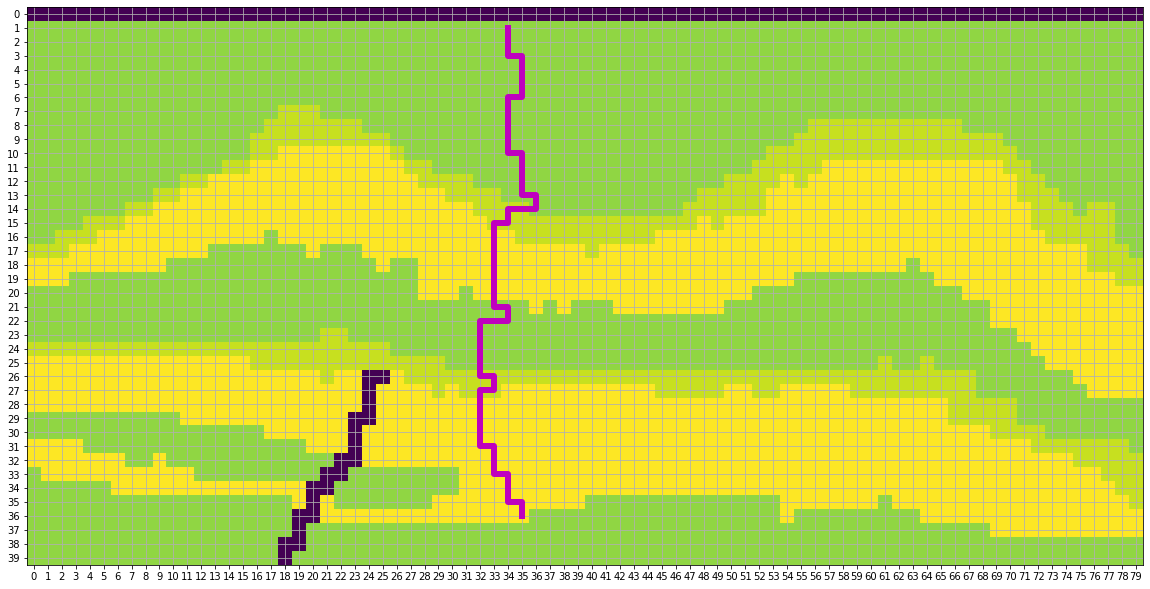

In [7]:
df = pd.DataFrame(env.trajectory, columns=["rows", "colums"])

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.grid()
plt.plot(df["colums"], df["rows"], "-", c="m", linewidth=6)

<Figure size 432x288 with 0 Axes>

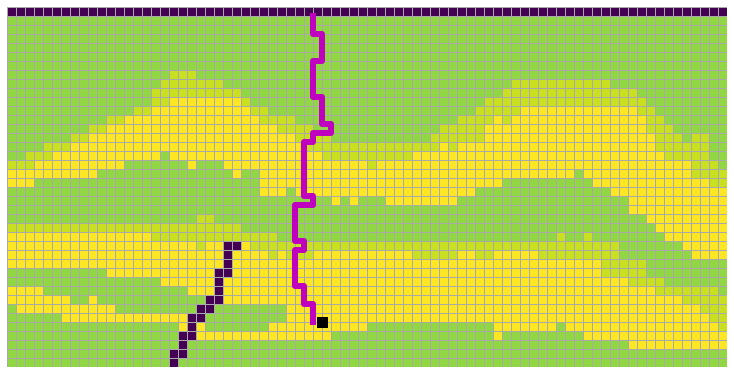

In [8]:
import matplotlib.animation as animation

plt.close("all")

fig = plt.figure(facecolor="white")
fig = plt.figure(figsize=(10, 5))
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
plt.pcolormesh(
    env.model, vmin=-10, vmax=2, antialiased=True, shading="auto", edgecolors="darkgray"
)
plt.gca().invert_yaxis()

borehole = ax.plot(df["colums"][0], df["rows"][0], ls="-", c="m", lw=6, zorder=10)
bit = ax.scatter(df["colums"][0], df["rows"][0], marker="s", s=100, c="k", zorder=20)


def animate_drill(i):
    borehole[0].set_data(df["colums"][:i], df["rows"][:i])
    bit.set_offsets([df["colums"][i], df["rows"][i]])


anim = animation.FuncAnimation(fig, frames=50, func=animate_drill)

FFwriter = animation.FFMpegWriter(fps=10, bitrate=500)
anim.save("animation.mp4", writer=FFwriter)